# Spotter Buoys - Quality Control Analysis

## Import libs

In [3]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
idx = pd.IndexSlice

import psycopg2
from dotenv import load_dotenv

from scipy.stats import normaltest, circmean, skew

import matplotlib.pyplot as plt
import seaborn as sns

import pnboia_qc.pnboia_limits as pnboia_limits
from pnboia_qc.qc_checks import QCChecks

import pnboia_qc.pnboia_limits_tests as pnboia_limits_tests
from pnboia_qc.lims_gen import *

import os

load_dotenv()

%load_ext autoreload
%autoreload 2

## Load data

- Get data from Alcatrazes, Noronha, Abrolhos and Imbituba

In [4]:
# GET DATA FROM PROD DB
# connect to the old db
con = psycopg2.connect(
                        host=os.getenv('host_old'),
                        database=os.getenv('db_old'),
                        user=os.getenv('user_old'),
                        password=os.getenv('pswd_old'),
                        port=5432, #set as default
                      )

# create the cursor
cur = con.cursor()

# retrieve data as a dataframe
table = "remobs.spotter_general"
query = f"""SELECT * FROM {table} 
            WHERE buoy_id IN 
                (SELECT buoy_id FROM remobs.buoys  
                    WHERE name_buoy = 'Alcatrazes' 
                    OR name_buoy = 'Noronha' 
                    OR name_buoy = 'Imbituba' 
                    OR name_buoy = 'abrolhos');"""

spot_data = sqlio.read_sql_query(query, con)
spot_data.set_index('date_time',inplace=True)

cur.close()

con.close()


/home/remobs-dados/.pyenv/versions/3.8.12/envs/pnboia_qc/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
# Limits from pnboia_limits_tests.py
# Note that the range limit for spotters swvht was corrected (1 -> 19.9)
spotters_lims = pnboia_limits_tests.spotters

## Preliminary Filtering

In [12]:
# filter data with
spot_filt = filter_data(data=spot_data,
                    limits=spotters_lims,
                    outlier_check=False,
                    t_continuity_check=False)

No mis_value_limit for wspd
No mis_value_limit for wdir
No mis_value_limit for sst
No mis_value_limit for swvht
No mis_value_limit for tp
No mis_value_limit for mean_tp
No mis_value_limit for pk_dir
No mis_value_limit for wvdir
mis_value_check done.
range_check done.


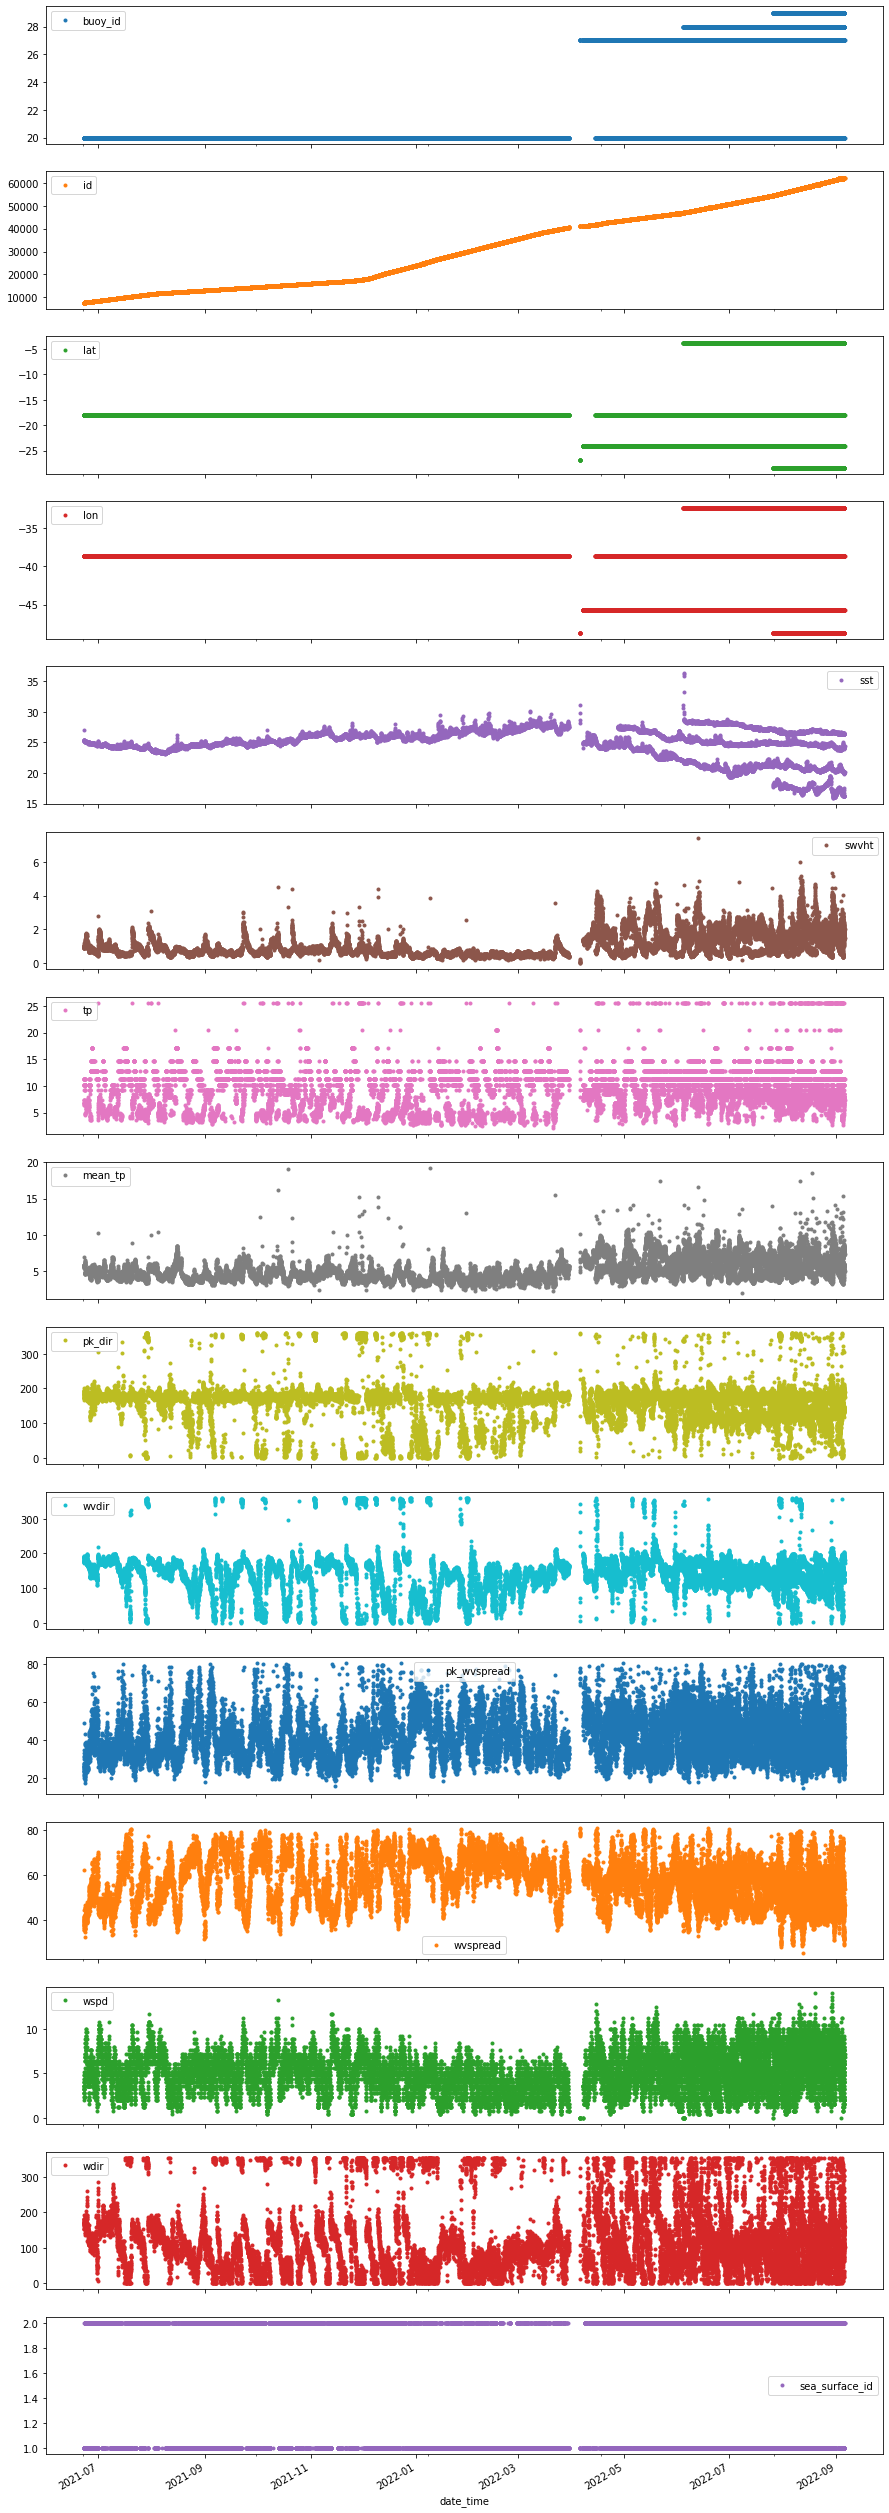

In [10]:
spot_data.plot(subplots=True, marker='.', ls='None', figsize=(15,50));

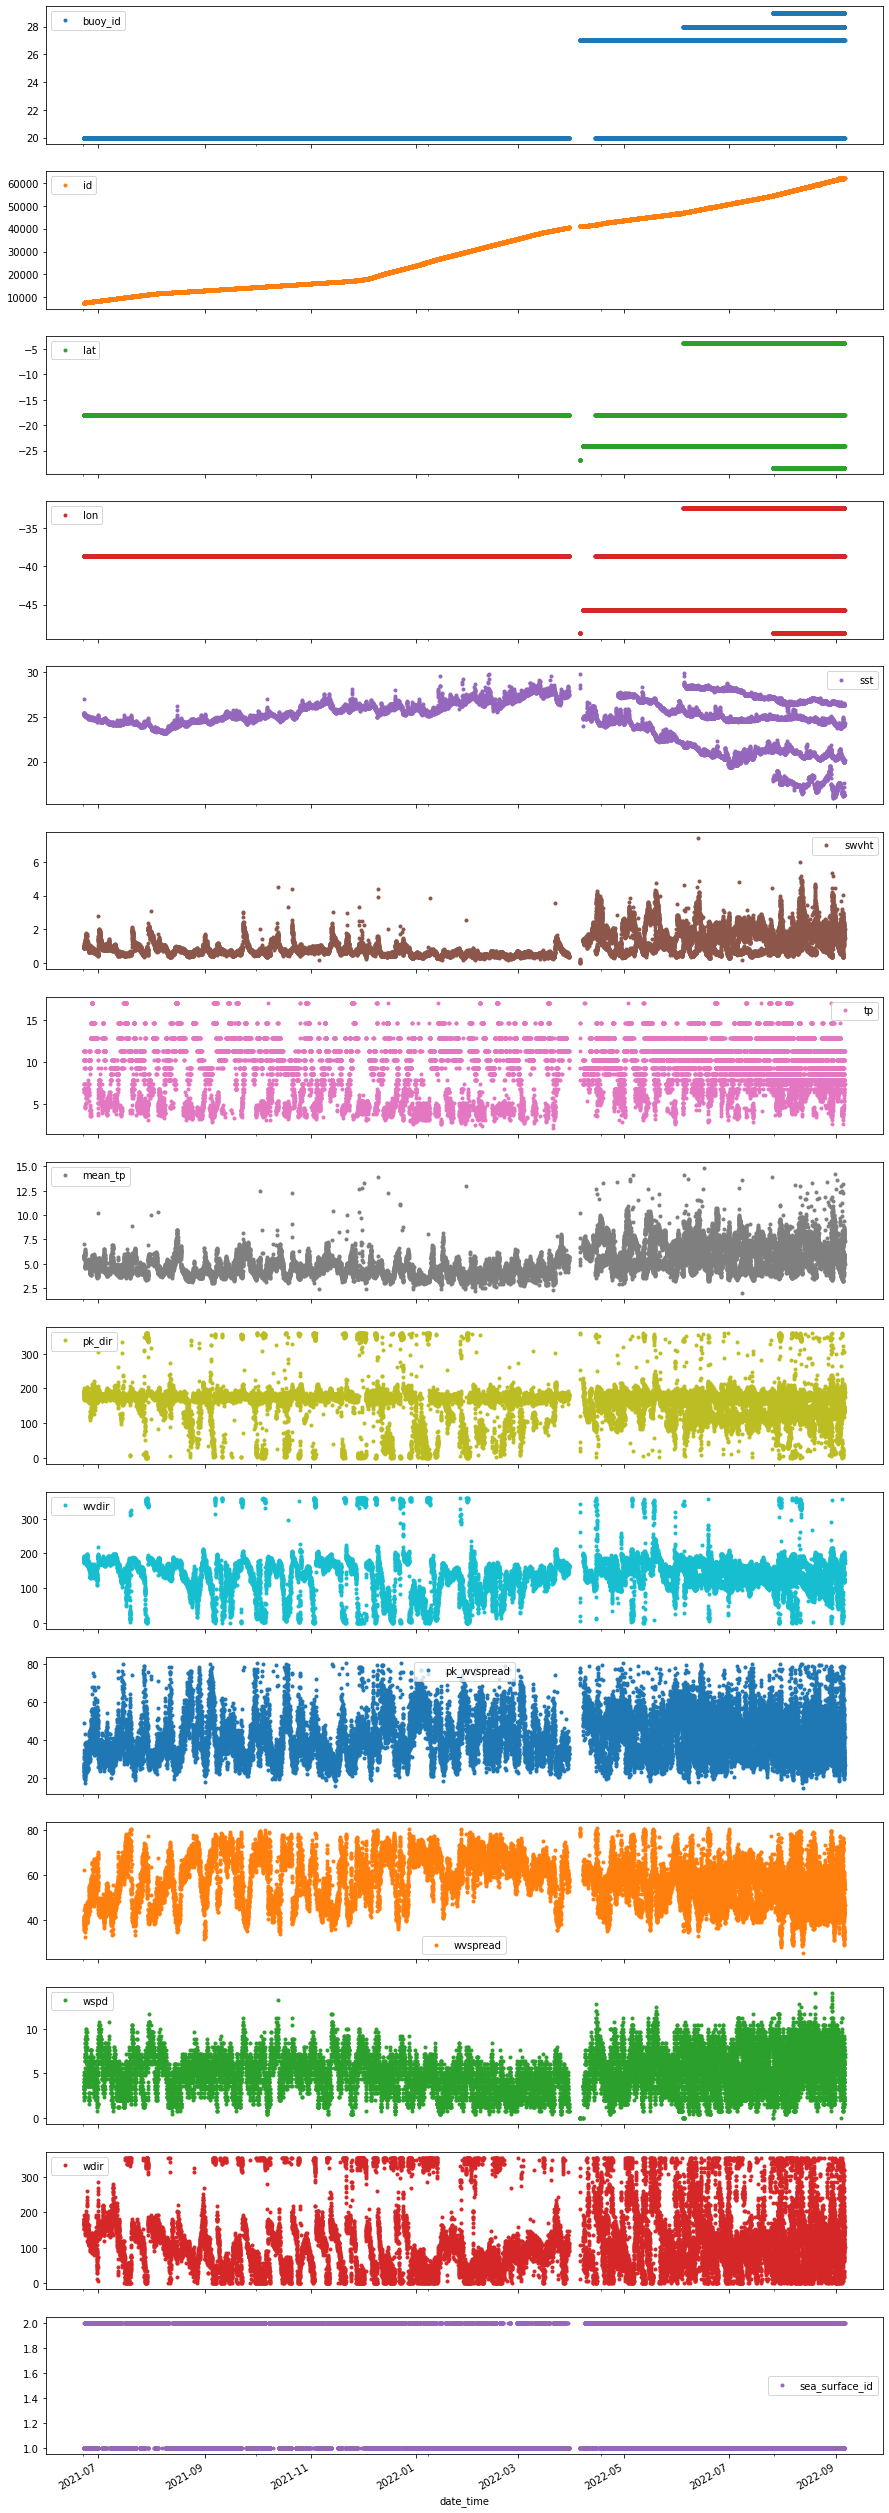

In [11]:
spot_filt.plot(subplots=True, marker='.', ls='None', figsize=(15,50));

## Statistical Analysis

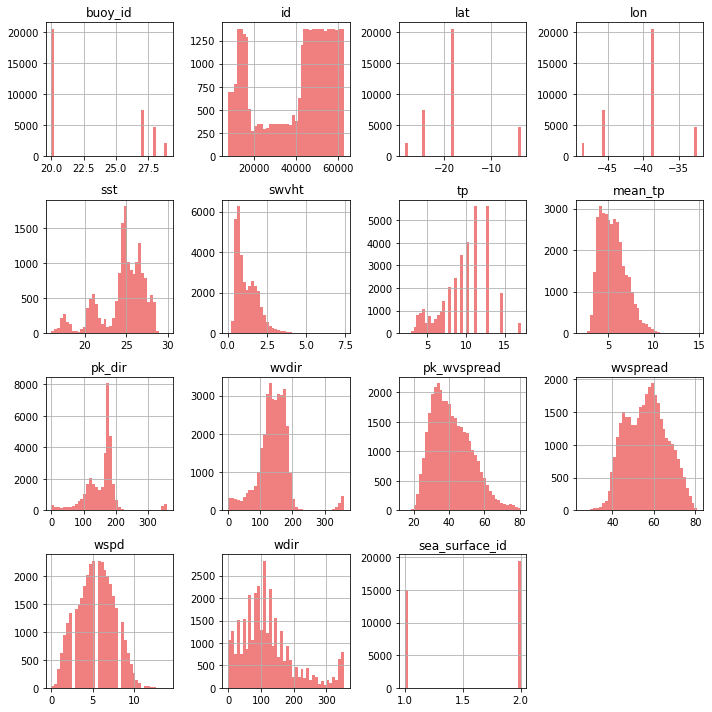

In [13]:
spot_filt.hist(bins=40, color='lightcoral', figsize=(10,10));
plt.tight_layout()

In [14]:
unw_cols = ['buoy_id','id','lat','lon','sea_surface_id']
raw_stats = spot_data.describe().loc[['mean','std','min','max']].round(2)
raw_stats.drop(columns=unw_cols)

,sst,swvht,tp,mean_tp,pk_dir,wvdir,pk_wvspread,wvspread,wspd,wdir
mean,24.57,1.22,9.75,5.52,155.42,140.33,41.55,56.53,5.36,121.54
std,2.73,0.70,3.39,1.47,51.68,51.30,11.32,9.82,2.22,82.50
min,15.94,0.03,2.12,2.02,0.07,0.10,14.86,25.08,0.00,0.00
max,36.40,7.42,25.60,19.24,360.00,360.00,80.62,81.03,14.00,354.00


In [15]:
filt_stats = spot_filt.describe().loc[['mean','std','min','max']].round(2)
filt_stats.drop(columns=unw_cols)

,sst,swvht,tp,mean_tp,pk_dir,wvdir,pk_wvspread,wvspread,wspd,wdir
mean,24.56,1.22,9.60,5.51,155.42,140.33,41.55,56.53,5.36,121.54
std,2.72,0.70,3.05,1.46,51.68,51.30,11.32,9.82,2.22,82.50
min,15.94,0.03,2.12,2.02,0.07,0.10,14.86,25.08,0.00,0.00
max,29.96,7.42,17.06,14.84,360.00,360.00,80.62,81.03,14.00,354.00


In [16]:
# Check diferences in raw data and filtered data statistics
raw_stats.compare(filt_stats)

sst            tp        mean_tp       
       self  other   self  other    self  other
mean  24.57  24.56   9.75   9.60    5.52   5.51
std    2.73   2.72   3.39   3.05    1.47   1.46
max   36.40  29.96  25.60  17.06   19.24  14.84

## Limits generation and data filtering

In [17]:
# Drop unwantetd columns for limit generation
spot_gen_lim_data = spot_filt.drop(columns=unw_cols)

In [18]:
# FACTOR 3
# Generated lims
spot_out_lims_df_3 = gen_outlier_lim(spot_gen_lim_data, buoy_name=None, std_factor=3).round(1)


# Generate lims dict
spot_out_lims_dict_3 = manual_outlier_lims(spot_out_lims_df_3)


# filter data with
spot3 = filter_data(data=spot_gen_lim_data,
                    buoy=None,
                    limits=spotters_lims,
                    mis_value_check=False,
                    range_check=False,
                    t_continuity_check=False,
                    outlier_limits=spot_out_lims_dict_3)

outlier_check done.


In [19]:
# FACTOR 5
# Generated lims
spot_out_lims_df_5 = gen_outlier_lim(spot_gen_lim_data, buoy_name=None, std_factor=5).round(1)


# Generate lims dict
spot_out_lims_dict_5 = manual_outlier_lims(spot_out_lims_df_5)


# filter data with
spot5 = filter_data(data=spot_gen_lim_data,
                    buoy=None,
                    limits=spotters_lims,
                    mis_value_check=False,
                    range_check=False,
                    t_continuity_check=False,
                    outlier_limits=spot_out_lims_dict_5)

outlier_check done.


In [20]:
spot_out_lims_df_3

,mean,std,factor,std*factor,lower_lim,upper_lim
param,,,,,,
sst,24.6,2.7,3.0,8.2,16.4,32.7
swvht,1.2,0.7,3.0,2.1,0.0,3.3
tp,9.6,3.1,3.0,9.2,0.4,18.8
mean_tp,5.5,1.5,3.0,4.4,1.1,9.9
pk_dir,155.4,51.7,3.0,155.0,0.4,310.5
wvdir,140.3,51.3,3.0,153.9,0.0,294.2
pk_wvspread,41.5,11.3,3.0,34.0,7.6,75.5
wvspread,56.5,9.8,3.0,29.5,27.1,86.0
wspd,5.4,2.2,3.0,6.7,0.0,12.0


In [21]:
spot_out_lims_df_5

,mean,std,factor,std*factor,lower_lim,upper_lim
param,,,,,,
sst,24.6,2.7,5.0,13.6,10.9,38.2
swvht,1.2,0.7,5.0,3.5,0.0,4.7
tp,9.6,3.1,5.0,15.3,0.0,24.9
mean_tp,5.5,1.5,5.0,7.3,0.0,12.8
pk_dir,155.4,51.7,5.0,258.4,0.0,413.8
wvdir,140.3,51.3,5.0,256.5,0.0,396.8
pk_wvspread,41.5,11.3,5.0,56.6,0.0,98.2
wvspread,56.5,9.8,5.0,49.1,7.4,105.6
wspd,5.4,2.2,5.0,11.1,0.0,16.5


# Testing generated limits

### sst

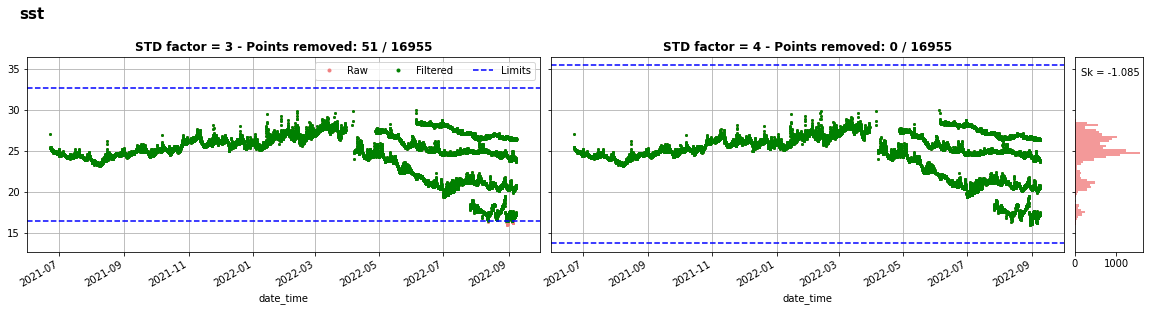

In [22]:
param = 'sst'
plot_comparison(factor1=3, 
                factor2=4, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### swvht

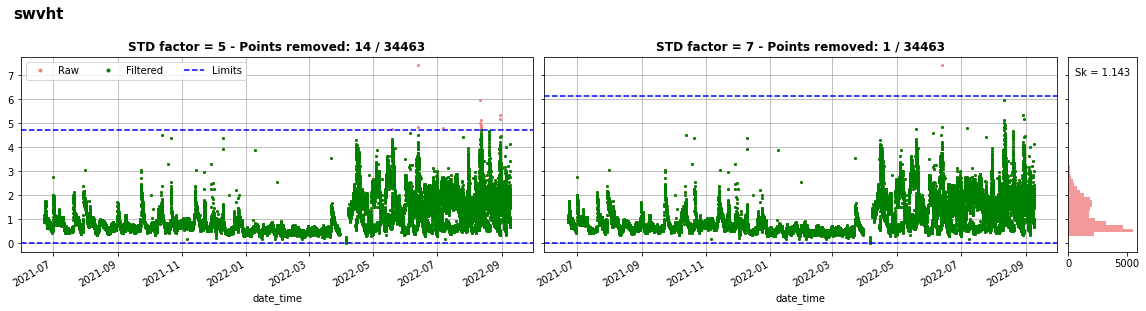

In [23]:
param = 'swvht'
plot_comparison(factor1=5, 
                factor2=7, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### tp

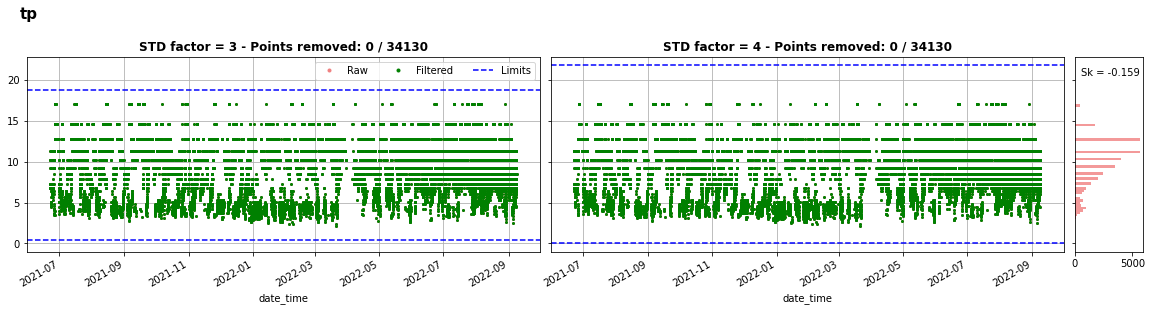

In [24]:
param = 'tp'
plot_comparison(factor1=3, 
                factor2=4, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                
                parameter=param)

### mean_tp

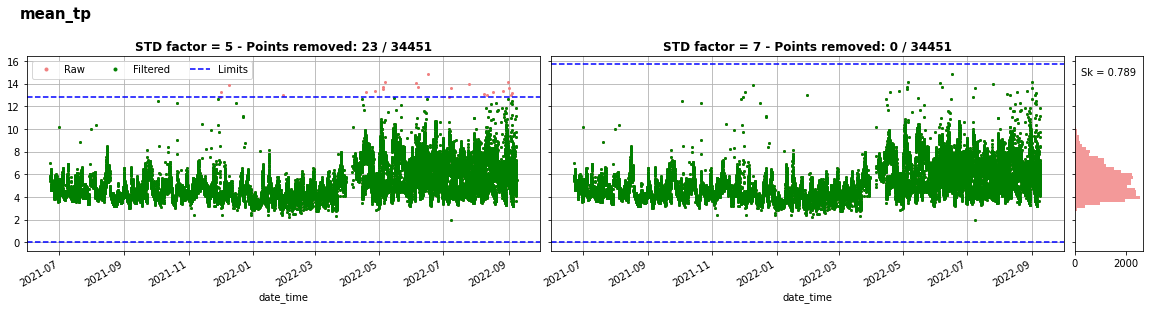

In [25]:
param = 'mean_tp'
plot_comparison(factor1=5, 
                factor2=7, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### wspd

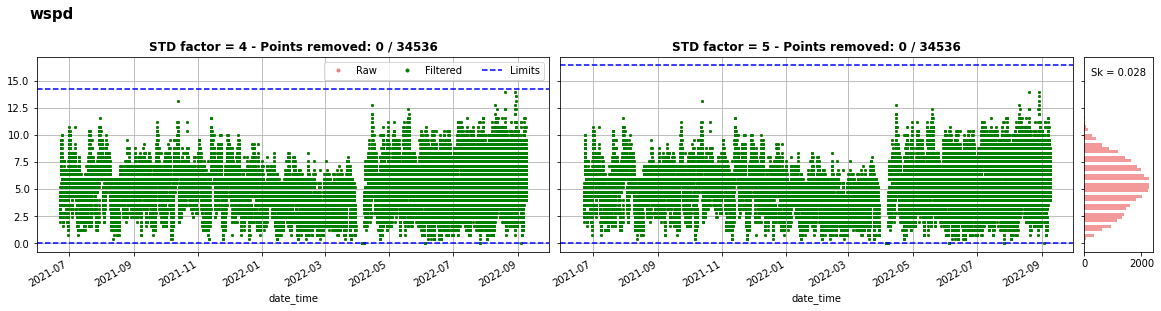

In [26]:
param = 'wspd'
plot_comparison(factor1=4, 
                factor2=5, 
                data=spot_gen_lim_data,
                limits=spotters_lims,
                buoy=None,
                parameter=param)

### Best factor for each parameter
- sst: 4
- swvht: 7
- tp: 3
- mean_tp: 5
- wspd: 5

In [38]:

# Factors per parameter
factors = {'sst': 4, # factor 4
            'tp': 3, # factor 3
            'mean_tp': 6, # factor 5
            'wspd': 5, # factor 5
            'swvht': 7}

# Generated lims
spot_gen_lim_data = spot_filt.drop(columns=['buoy_id','id','lat','lon','sea_surface_id'])
spot_out_lims_df = gen_outlier_lim(data=spot_gen_lim_data,
                                   std_factor=factors).round(1)

# Generate lims dict
spot_out_lims_dict = manual_outlier_lims(spot_out_lims_df.dropna())

In [39]:
spot_out_lims_df.dropna()

,mean,std,factor,std*factor,lower_lim,upper_lim
param,,,,,,
sst,24.6,2.7,4.0,10.9,13.7,35.5
swvht,1.2,0.7,7.0,4.9,0.0,6.1
tp,9.6,3.1,3.0,9.2,0.4,18.8
mean_tp,5.5,1.5,6.0,8.7,0.0,14.2
wspd,5.4,2.2,5.0,11.1,0.0,16.5


In [40]:
spot_out_lims_dict

{'sst': [13.7, 35.5],
 'swvht': [0.0, 6.1],
 'tp': [0.4, 18.8],
 'mean_tp': [0.0, 14.2],
 'wspd': [0.0, 16.5]}

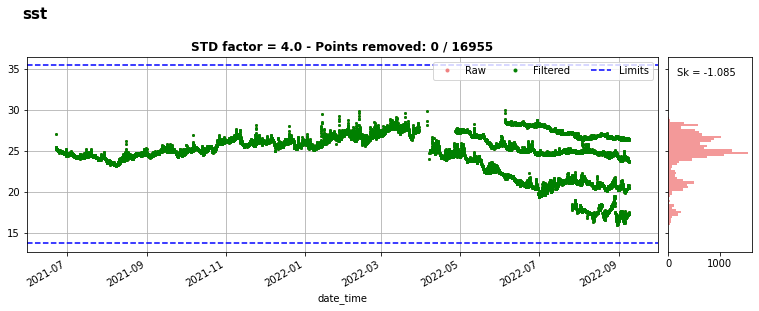

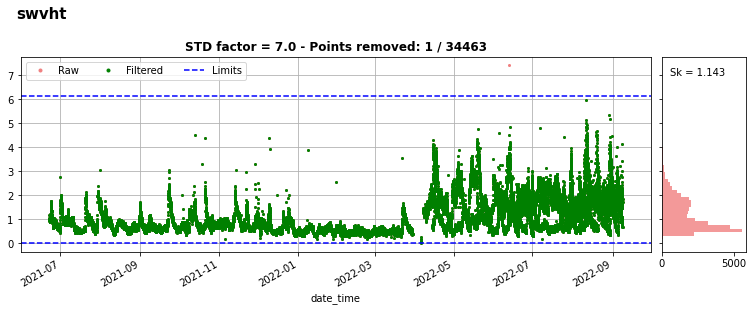

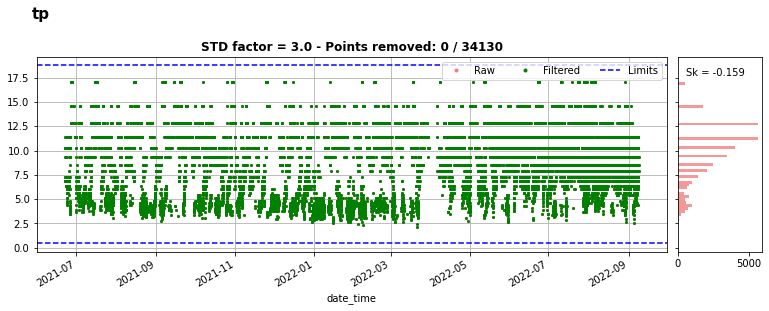

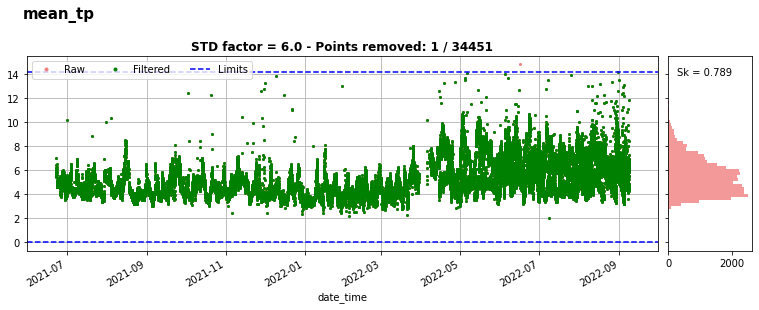

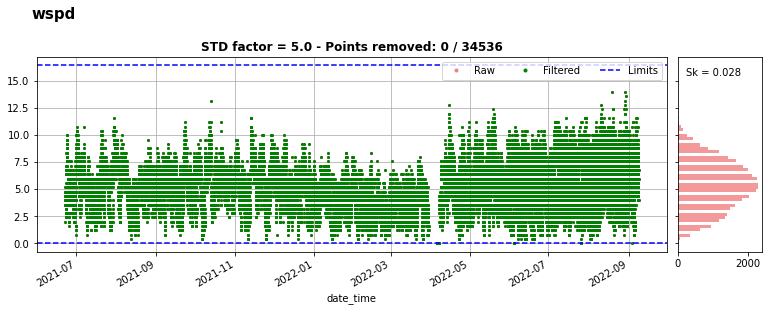

In [41]:
# FILTERING WITH DEFINITIVE FACTORS
spot_notdir = spot_gen_lim_data.drop(columns=spot_gen_lim_data.filter(regex='dir|head|spread').columns)
parameters = spot_notdir.columns

for param in parameters:

    plot_filtering(factor=factors,
                    data=spot_gen_lim_data,
                    limits=spotters_lims,
                    buoy=None,
                    parameter=param)
    plt.show()